In [683]:
import h5py    
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
from IPython.display import clear_output
import multiprocessing as mp
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
# figsize(10,8)



In [684]:
import h5py as h5
l1 = h5.File('./data/CFIS_L1_NGDCS20170619t184335_cal_2018_v2.h5','r')
spectra_ = np.array(l1['camera/radiances'][:])
wlSize=2048
disp = np.asarray([-1.2553e-6,0.0201,735.4572])
ind = np.linspace(1,wlSize,wlSize)
wlGrid_ = np.polyval(disp,ind )
wlGrid = wlGrid_[(wlGrid_>747)&(wlGrid_<756)]
spectra_ = spectra_[:,(wlGrid_>747)&(wlGrid_<756),:]
l1.close()



In [685]:
# Read in tabulated pre-computed dataset.
sun = np.loadtxt('data/solar_merged_20160127_600_26316_100.out')
# interpolate to common grid in wavelength (not wavenumber), use 0.002nm sampling here
res = 0.002
# create wavelength grid in nm
wl = np.arange(727,776,res)
# Solar transmission spectrum, resample to wavelength grid (from wavenumber):
f = interp1d(1.e7/sun[:,0], sun[:,1])
Tsun = f(wl)
co = 2.355
T_cfis = gaussian_filter1d(Tsun, 0.07/res/co)




In [686]:
wl.shape

(24500,)

In [687]:
SIF_shape.shape

(501,)

In [688]:
f1 = h5py.File('./data/PS_SIF_map_easy.h5','r')    
f1_keys=list(f1.keys())
list(f1.keys())
SIF_shape_ = f1['SIF_shape'][:] # (437,)

wl_sif = f1['wlGrid'][:] # dwlGrid = 0.03 (437,)
f = interp1d(wl_sif,SIF_shape_,fill_value="extrapolate")
SIF_shape = f(wlGrid)
f1.close()

In [689]:
co = 2.355


class Setup:
    pass
mySetup = Setup()

mySetup.FWHM = 0.07
# wo = np.where((wl_solarSpectrum>743)&(wl_solarSpectrum<757))[0]
# mySetup.wl_so = wl

mySetup.wl_in = wl
mySetup.wl_out = wlGrid
mySetup.res = 0.01 # wlGrid[1:]-wlGrid[0:-1]




In [690]:
# reference solar spectrum
# Lo = Tsun*s_base/np.pi # mW/M2/SR/UM
Tsun = T_cfis.copy()
Lo = Tsun/np.pi 

In [847]:

def forward_model_shift(x,b,compK = False):
    poly_wl = x[0:3]
    poly = x[-4:-1]
    a = x[-1]
#     c1 = x[0]; p0 = x[1]; p1 = x[2]; p2 = x[3]; a = x[4]
    

    Lo_conv = gaussian_filter1d(Lo,b.FWHM/b.res/co)
    
    detPixels = len(b.wl_in)
    grid = np.arange(0,detPixels,1)-detPixels/2.
#     wl_shifted = grid+c1 # b.nu_out in the example 8
    wl_shifted = np.polyval(poly_wl,grid)
    
    finter1 = interp1d(grid, Lo_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_conv_shifted = finter1(wl_shifted)
    
    finter2 = interp1d(b.wl_in, Lo_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_1 = finter2(b.wl_out)# output Lo
    
    dwl = b.wl_out-np.mean(b.wl_out)
    F_ref_nosif = Lo_1*np.polyval(poly,dwl)
    F_forward = F_ref_nosif+a*SIF_shape

    if compK:
        K = np.zeros((len(b.wl_out),len(x)))
#         dx = [5e-6,5e-6,5e-6]
        dx = [1e-6,1e-6,1e-6]
        for i in range(3):
            poly_wl2 = poly_wl.copy()
            poly_wl2[i] = poly_wl[i]+dx[i]
#             c1_2 = c1 + dx
            Lo_2 = finter1(np.polyval(poly_wl2,grid))
            finter3 = interp1d(b.wl_in, Lo_2,kind='linear', fill_value=np.NaN,bounds_error=False)
            Lo_2 = finter3(b.wl_out)
            FF = Lo_2*np.polyval(poly,dwl)+a*SIF_shape

            K[:,i] = (FF-F_forward)/dx[i]# partial I partial c1
        K[:,-4] = Lo_1*dwl**2 # partial I partial p0
        
        K[:,-3] = Lo_1*dwl# partial I partial p1
        K[:,-2] = Lo_1# partial I partial p2
        K[:,-1] = SIF_shape# partial I partial a
    if compK:
        return F_forward,K
    else:
        return F_forward


def iterate_fit(x0,b,F,n_itr=500,thrs = 1e-3):
    chi2_r_old = 1e9
    DOF = len(F)-len(x0)
    invSe = noise_model(F)
    F0_guess,K = forward_model_shift(x0,b,compK=True)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x = x0+ Gain.dot(F-F0_guess)
    F0,K = forward_model_shift(x,b,compK=True)
    chi2 = np.sum((F0-F0_guess)**2*np.diag(invSe))
    chi2_r = chi2/DOF
    print(xa)
    chi2_r_itr =[];x_linear_itr=[];sif_1sigma_itr=[]
    for i in range(n_itr):
        
        
#         #F0,K = forward_model_shift(x,b,compK=True)
#         #### uncomment the below if no prior
#         Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
        
#         x_plus1 = x+ Gain.dot(F-F0)
#         ####
        
        ####
# #         add prior
        x_plus1 = x + np.linalg.inv(K.T.dot(invSe).dot(K)+invSa).dot(K.T.dot(invSe).dot(F-F0)-invSa.dot(x-xa))
        print(x_plus1.shape)
        ####
        S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
        sif_1sigma = np.sqrt(S_posterior[-1,-1])
        #F2 = forward_model_shift(x_plus1,b)
        F2,K_new = forward_model_shift(x_plus1,b,compK=True)
        chi2 = np.sum((F2-F)**2*np.diag(invSe))
        chi2_r = chi2/DOF
        chi2_r_itr.append(chi2_r)
        x_linear_itr.append(x_plus1)
        sif_1sigma_itr.append(sif_1sigma)
        if abs(chi2_r-chi2_r_old) < thrs:
            print('iteration %d' %i)
            break
        else:
            x = x_plus1.copy() 
            chi2_r_old = chi2_r.copy()
            F0 = F2.copy()
            K = K_new.copy()
            
        
    return x_linear_itr,sif_1sigma_itr,chi2_r_itr



def noise_model(F):
# '''This is the noise model for each point on the map'''
# '''F is the measured radiance, which is a function of wavelength'''
    
    invSe = np.zeros((len(F),len(F)))
    
    noise = np.sqrt(F)/40
    
    invSe=np.diag(1./(noise**2) )
    return invSe


def linear_fit(F):
    invSe = noise_model(F)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x_linear = Gain.dot(F)
    S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
    sif_1sigma = np.sqrt(S_posterior[-1,-1])
    chi2 = np.sum((np.dot(K,x_linear)-F)**2*np.diag(invSe))
    chi2_r = chi2/(len(F)-len(x_linear))
    return x_linear,sif_1sigma,chi2_r

In [848]:
spectra = np.mean(spectra_[100,:,500:600],axis=-1)
print(spectra_.shape)

(256, 501, 1432)


In [849]:
F_forward,K = forward_model_shift([0,1,40]+[0.132,0.38,233.1,0],mySetup,compK=True)

x_linear,sif_1sigma,chi2_r = linear_fit(spectra)


In [850]:
#add prior info
xa =[0,0,0]+list(x_linear[3:]) #[0,0,0,0,0,0,10]

invSa = np.zeros((len(xa),len(xa)))

for i in range(7):
    invSa[i,i] = 1/(1**2)

In [851]:
len(xa)

7

In [852]:
x_linear

array([ 3.94478646e-07, -6.17453408e-04, -1.03658336e+01,  1.32109478e-01,
        9.26986166e-01,  2.15555208e+02,  5.79035177e+00])

In [853]:
chi2_r

1.8312637073990092

Text(0.5,1,'linear retrievel one step')

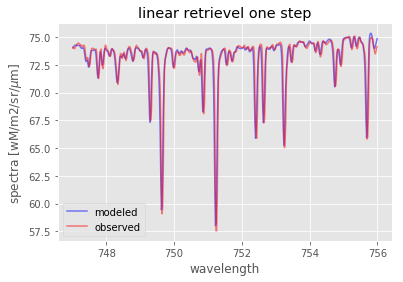

In [854]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('linear retrievel one step')

Text(0.5,1,'F_forward-F_observed')

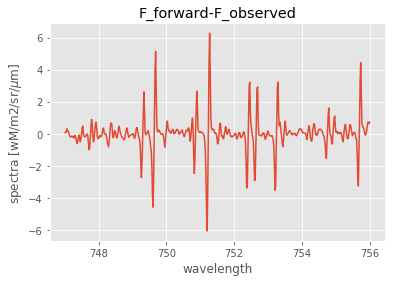

In [855]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [856]:
ma,mb,mc = iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)

[0, 0, 0, 0.13210947775927578, 0.9269861661871345, 215.5552080805478, 5.7903517707577015]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 61


In [857]:
len(ma)

62

In [858]:
np.array(ma)[:,-1]

array([1.42113001, 1.40709376, 1.40710087, 1.40672888, 1.40677979,
       1.4067687 , 1.40677339, 1.40677072, 1.40677238, 1.40677133,
       1.40677199, 1.40677158, 1.40677184, 1.40677167, 1.40677178,
       1.40677171, 1.40677175, 1.40677173, 1.40677174, 1.40677174,
       1.40677174, 1.40677173, 1.40677174, 1.40677174, 1.40677174,
       1.40677174, 1.40677173, 1.40677174, 1.40677174, 1.40677174,
       1.40677174, 1.40677174, 1.40677174, 1.40677174, 1.40677174,
       1.40677174, 1.40677174, 1.40677174, 1.40677174, 1.40677174,
       1.40677174, 1.40677174, 1.40677174, 1.40677174, 1.40677174,
       1.40677174, 1.40677174, 1.40677174, 1.40677174, 1.40677174,
       1.40677174, 1.40677174, 1.40677174, 1.40677174, 1.40677174,
       1.40677174, 1.40677174, 1.40677174, 1.40677174, 1.40677174,
       1.40677174, 1.40677174])

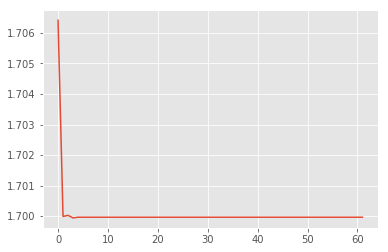

In [859]:
plt.plot(mc)

In [860]:
ma

[array([2.56293686e-07, 9.99341987e-01, 2.97250339e+01, 1.24039948e-01,
        4.63357542e-01, 2.28831301e+02, 1.42113001e+00]),
 array([2.59147348e-07, 9.99365255e-01, 2.97524301e+01, 1.23993015e-01,
        4.61831978e-01, 2.28874019e+02, 1.40709376e+00]),
 array([2.55346330e-07, 9.99368556e-01, 2.97545007e+01, 1.23992574e-01,
        4.61843676e-01, 2.28873995e+02, 1.40710087e+00]),
 array([2.55921169e-07, 9.99367719e-01, 2.97542767e+01, 1.23991925e-01,
        4.61801816e-01, 2.28875127e+02, 1.40672888e+00]),
 array([2.55795377e-07, 9.99368091e-01, 2.97542354e+01, 1.23991899e-01,
        4.61807785e-01, 2.28874972e+02, 1.40677979e+00]),
 array([2.55835048e-07, 9.99368018e-01, 2.97542032e+01, 1.23991897e-01,
        4.61806485e-01, 2.28875006e+02, 1.40676870e+00]),
 array([2.55812569e-07, 9.99368071e-01, 2.97542211e+01, 1.23991890e-01,
        4.61807052e-01, 2.28874992e+02, 1.40677339e+00]),
 array([2.55826554e-07, 9.99368037e-01, 2.97542100e+01, 1.23991896e-01,
        4.61806726

In [861]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

Text(0.5,1,'non-linear retrievel last step')

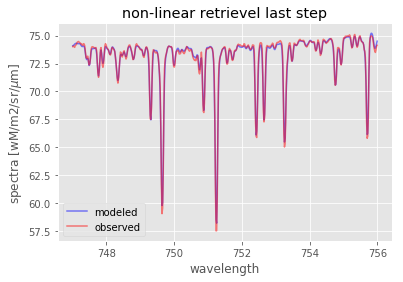

In [862]:

plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

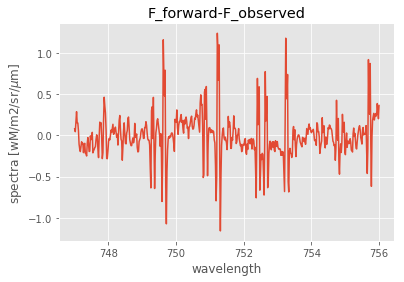

In [863]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [770]:
spectra2 =spectra_[220,:,550]
F_forward,K = forward_model_shift([0,1,40]+[0.132,0.38,233.1,0],mySetup,compK=True)
x_linear,sif_1sigma,chi2_r = linear_fit(spectra2)
#add prior info
xa =[0,0,0]+list(x_linear[3:]) #[0,0,0,0,0,0,10]
invSa = np.zeros((len(xa),len(xa)))
for i in range(3,7):
    invSa[i,i] = 1/(0.4**2)

Text(0.5,1,'non-linear retrievel last step')

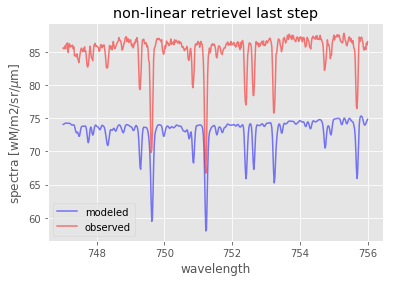

In [771]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra2,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

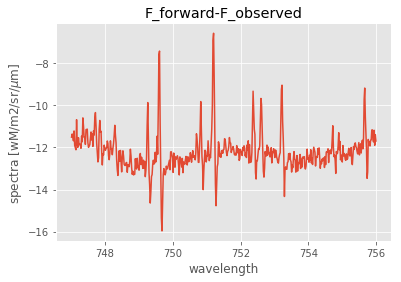

In [772]:
plt.plot(mySetup.wl_out,F_forward-spectra2)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [773]:

ma,mb,mc =iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra2,n_itr=200,thrs=1e-10)

[0, 0, 0, 0.030215336330923312, 0.4762422107337096, 270.0384626054627, 0.9359223855462133]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 33


In [774]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

In [775]:
ma

[array([1.19338384e-07, 9.98691138e-01, 4.54547823e+01, 3.08213759e-02,
        4.41557150e-01, 2.71026350e+02, 6.06133971e-01]),
 array([1.01855456e-07, 9.98691811e-01, 4.56318758e+01, 3.08786080e-02,
        4.38700344e-01, 2.71105476e+02, 5.79643358e-01]),
 array([1.00576513e-07, 9.98699622e-01, 4.56150596e+01, 3.08768662e-02,
        4.38647871e-01, 2.71107411e+02, 5.78996021e-01]),
 array([1.01051853e-07, 9.98694878e-01, 4.56186883e+01, 3.08802401e-02,
        4.38642243e-01, 2.71107368e+02, 5.79009168e-01]),
 array([1.00971978e-07, 9.98694962e-01, 4.56187317e+01, 3.08802215e-02,
        4.38643637e-01, 2.71107332e+02, 5.79021309e-01]),
 array([1.00977864e-07, 9.98694959e-01, 4.56187270e+01, 3.08802249e-02,
        4.38643404e-01, 2.71107338e+02, 5.79019231e-01]),
 array([1.00977344e-07, 9.98694959e-01, 4.56187274e+01, 3.08802246e-02,
        4.38643421e-01, 2.71107337e+02, 5.79019387e-01]),
 array([1.00977373e-07, 9.98694959e-01, 4.56187274e+01, 3.08802247e-02,
        4.38643420

In [776]:
np.array(ma)[:,-1]

array([0.60613397, 0.57964336, 0.57899602, 0.57900917, 0.57902131,
       0.57901923, 0.57901939, 0.57901937, 0.57901937, 0.57901938,
       0.57901938, 0.57901937, 0.57901937, 0.57901937, 0.57901938,
       0.57901937, 0.57901937, 0.57901937, 0.57901938, 0.57901937,
       0.57901937, 0.57901937, 0.57901937, 0.57901937, 0.57901937,
       0.57901937, 0.57901938, 0.57901937, 0.57901937, 0.57901937,
       0.57901937, 0.57901937, 0.57901937, 0.57901937])

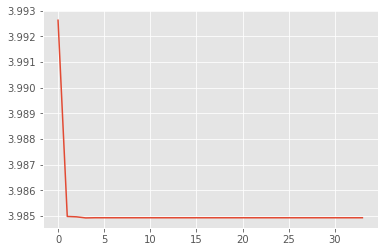

In [777]:
plt.plot(mc)

Text(0.5,1,'spectra 2 non-linear retrievel last step')

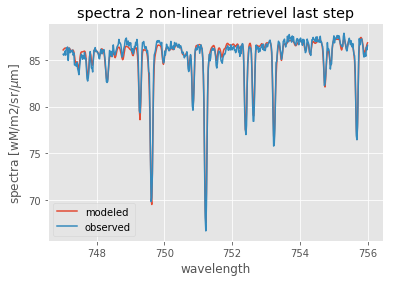

In [778]:

plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra2,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 non-linear retrievel last step')

Text(0.5,1,'spectra 2 F_forward-F_observed')

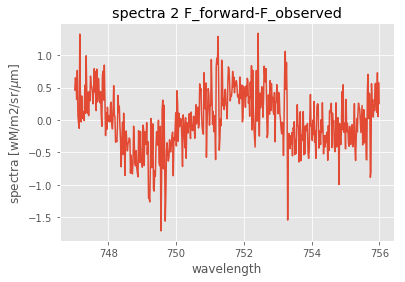

In [779]:
plt.plot(mySetup.wl_out,F_forward-spectra2)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 F_forward-F_observed')

In [780]:
np.array(ma)[:,-1]

array([0.60613397, 0.57964336, 0.57899602, 0.57900917, 0.57902131,
       0.57901923, 0.57901939, 0.57901937, 0.57901937, 0.57901938,
       0.57901938, 0.57901937, 0.57901937, 0.57901937, 0.57901938,
       0.57901937, 0.57901937, 0.57901937, 0.57901938, 0.57901937,
       0.57901937, 0.57901937, 0.57901937, 0.57901937, 0.57901937,
       0.57901937, 0.57901938, 0.57901937, 0.57901937, 0.57901937,
       0.57901937, 0.57901937, 0.57901937, 0.57901937])

In [782]:

SIF = []; SIF_1SIGMA = [];CHI2_R = []
for i in range(100,102):
    for j in range(10,20):
        spectra = spectra_[i,:,j]
        _,K = forward_model_shift([0,1,40]+[0.132,0.38,233.1,0],mySetup,compK=True)
        x_linear,sif_1sigma,chi2_r = linear_fit(spectra)
        #add prior info
        xa =[0,0,0]+list(x_linear[3:]) #[0,0,0,0,0,0,10]
        invSa = np.zeros((len(xa),len(xa)))
        invSa[6,6] = 1/(0.1**2)
        ma,mb,mc =iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)
        SIF.append(ma[-1][-1])
        SIF_1SIGMA.append(mb[-1])
        CHI2_R.append(mc[-1])
        

[0, 0, 0, 0.1409953240801538, 2.1123578725519243, 292.26325769990996, 9.214142847584453]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 50
[0, 0, 0, 0.16288541390148836, 1.187628739626063, 270.3364116510969, 7.4104112281385]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 45
[0, 0, 0, 0.16347580326241434, 1.8884529703998567, 324.93464313582706, 6.824767029525125]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 17
[0, 0, 0, 0.13631117962923986, 1.5671173902683044, 262.0256635444129, 7.309459157875423]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7

(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
[0, 0, 0, 0.16263224534368612, 1.3517916229317217, 293.2661706753395, 7.1748265794814134]
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
iteration 101
[0, 0, 0, 0.1628550596571894, 0.7985245110069776, 2

In [110]:
SIF = np.reshape(np.array(SIF),(2,10))

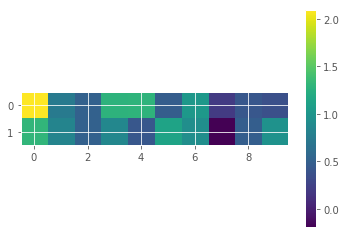

In [111]:
plt.imshow(np.array(SIF))
plt.colorbar()

In [108]:
SIF

array([[1.11705576, 0.5830816 , 0.60389113, 1.15996298, 1.02729951,
        0.55275171, 0.79666046, 0.39140188, 0.5566552 , 0.50727497],
       [0.7752244 , 0.65195165, 0.81342446, 0.99977152, 0.64872309,
        0.99044986, 0.86398036, 0.22664276, 0.69554782, 0.97136556]])

In [112]:
SIF

array([[ 2.09268259,  0.75080587,  0.51744511,  1.28318748,  1.29728309,
         0.47797077,  1.02917044,  0.20267548,  0.42839246,  0.36556143],
       [ 1.31247678,  0.84255759,  0.51732899,  0.86189353,  0.42641457,
         1.13372404,  0.93544833, -0.19239609,  0.48807547,  0.97136556]])